Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "Daily total female births in California": female_births["Count"]
}

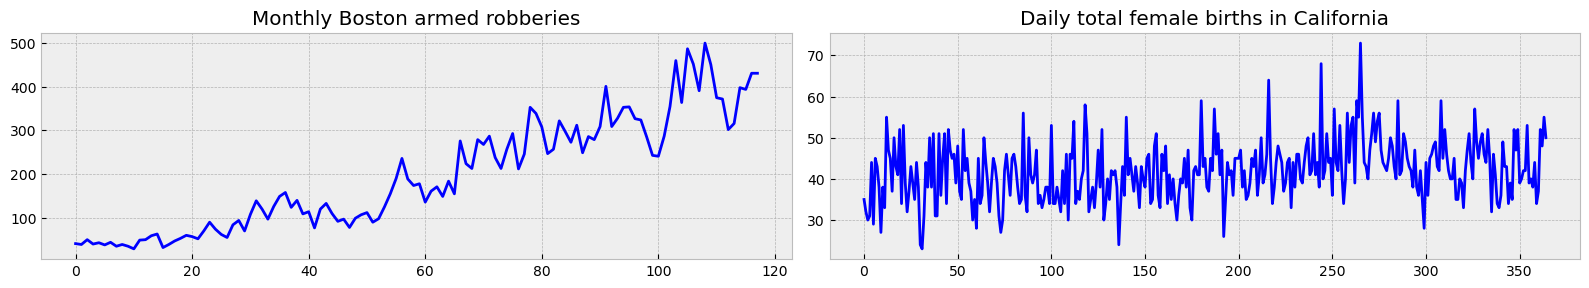

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Функции для проверки стационарности:

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# 1. monthly sales of company x

###### Проверяем на стационарность ряд без обработки

In [7]:
series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


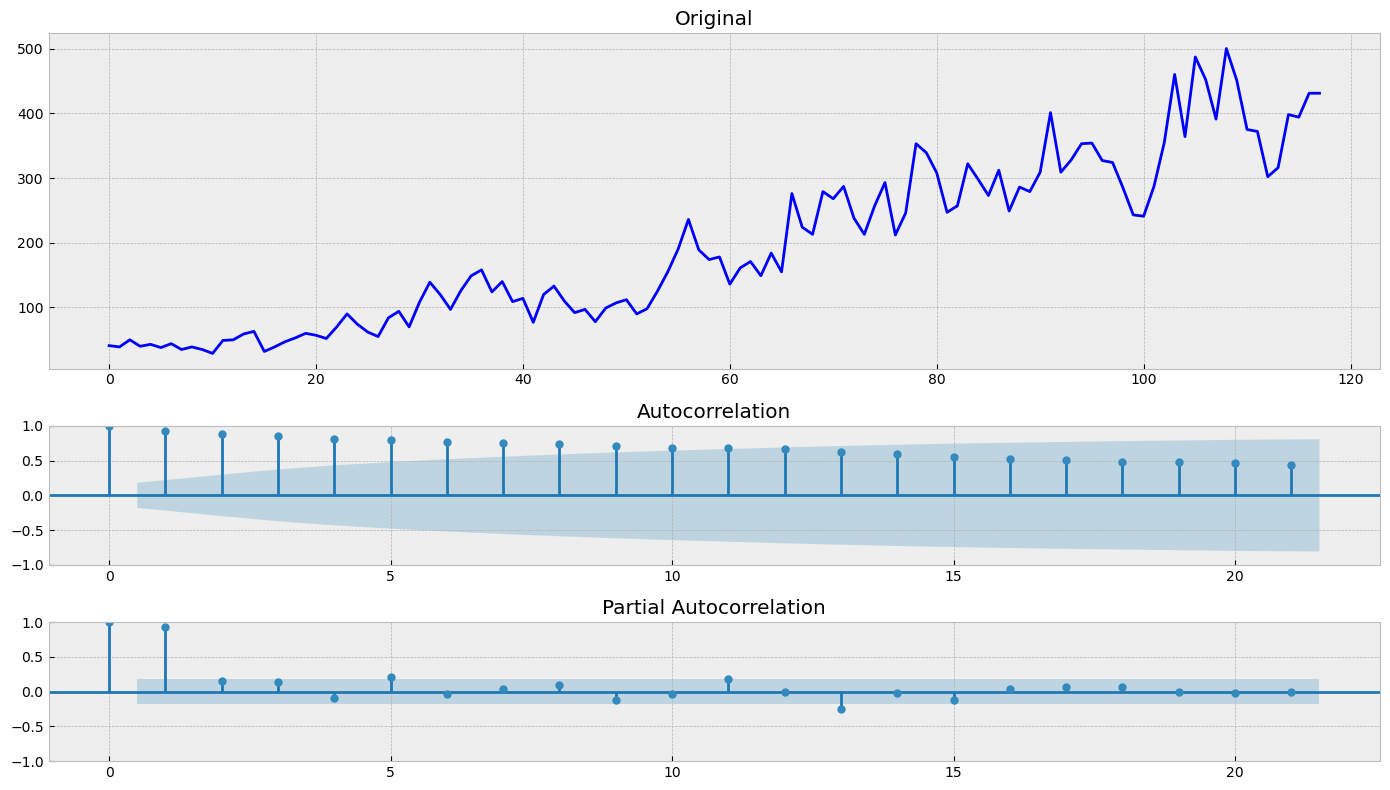

In [8]:
tsplot(series) #если p-value меньше чем 0.5, значит временной ряд стационарен

Не стационарный временной ряд.

Тут есть тренд. Значит, для предсказания можем использовать двойное экспоненциальное сглаживание.

In [9]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [12]:
def plot_dema(alpha, beta):
    dema = double_ema(robberies_in_boston["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(robberies_in_boston["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

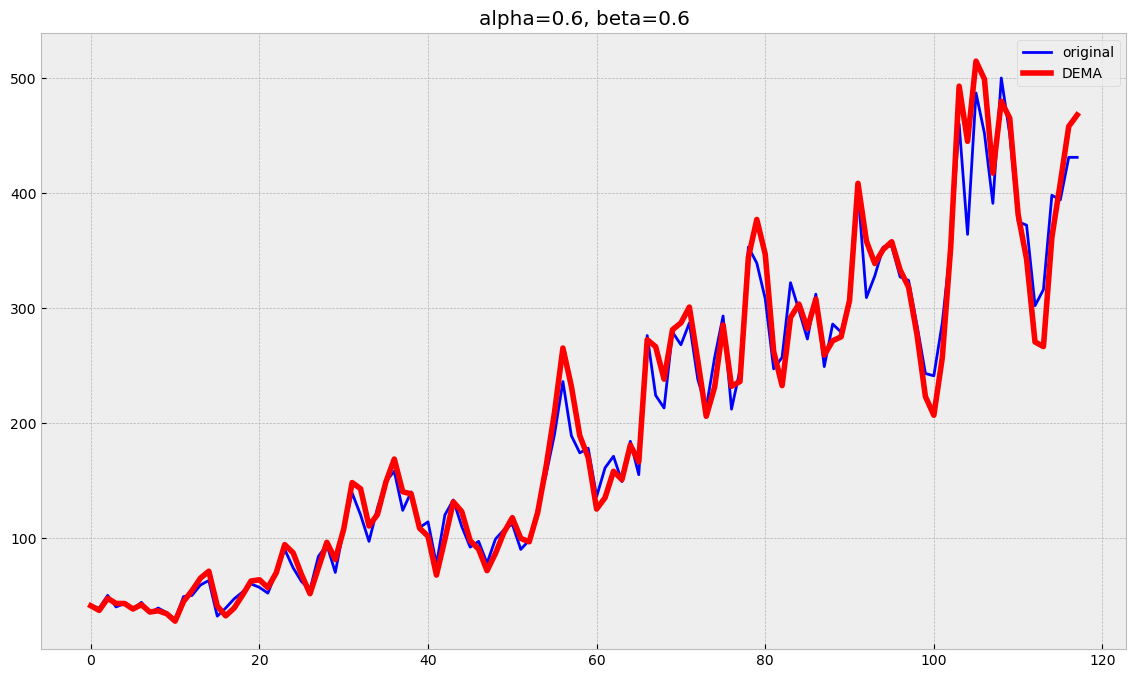

In [15]:
plot_dema(0.6, 0.6)
#первый параметр - учитывает дальность измерения (чем измерение ближе, тем больше вклад). 
#чем ближе к нулю, тем больше будет сглаживание

#второй параметр - учитывает тренд

Попробую разные параметры вставить, хотя на мой взляд, исходные уже весьма хороши.

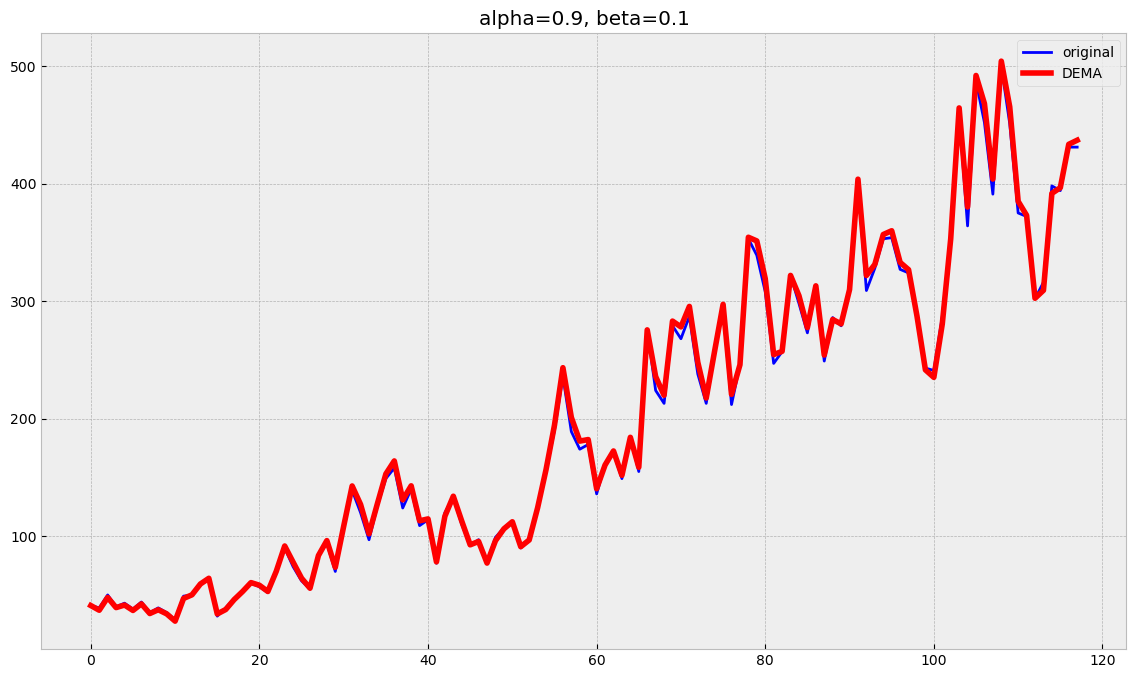

In [40]:
plot_dema(0.9, 0.1) #очень низкое влияние тренда, но сильно учитываем дальность измерения
#почти совпадает с исходным

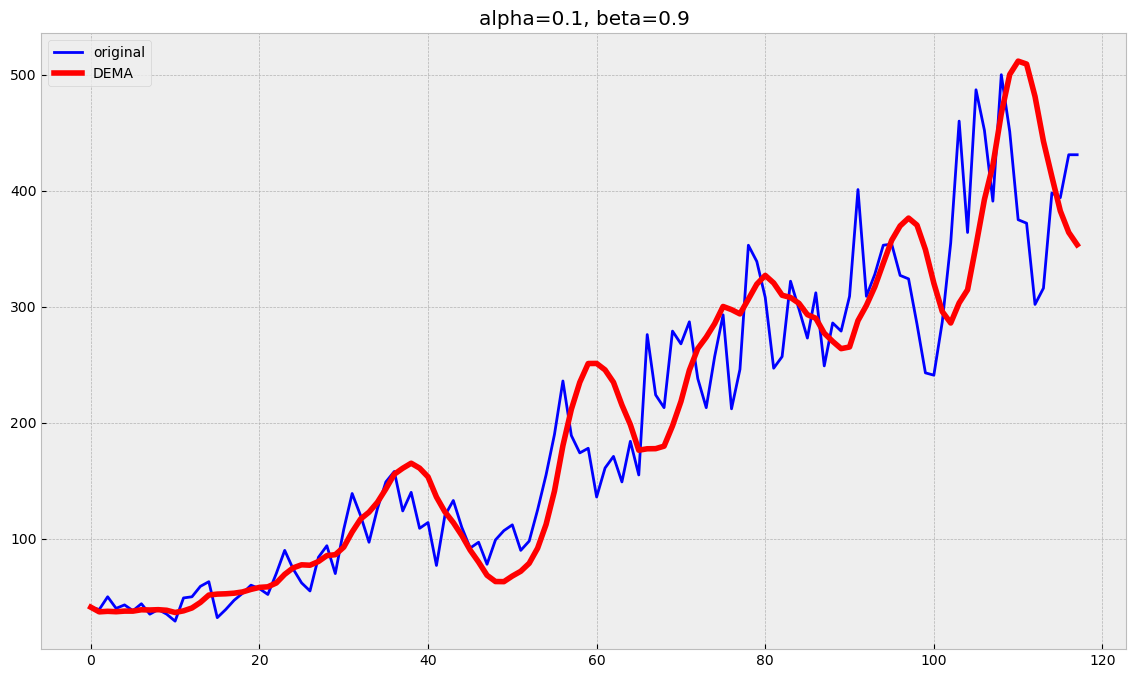

In [41]:
plot_dema(0.1, 0.9) #наоборот, сгладили ряд. прям сильные расхождения.

# 2.Daily total female births in California

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


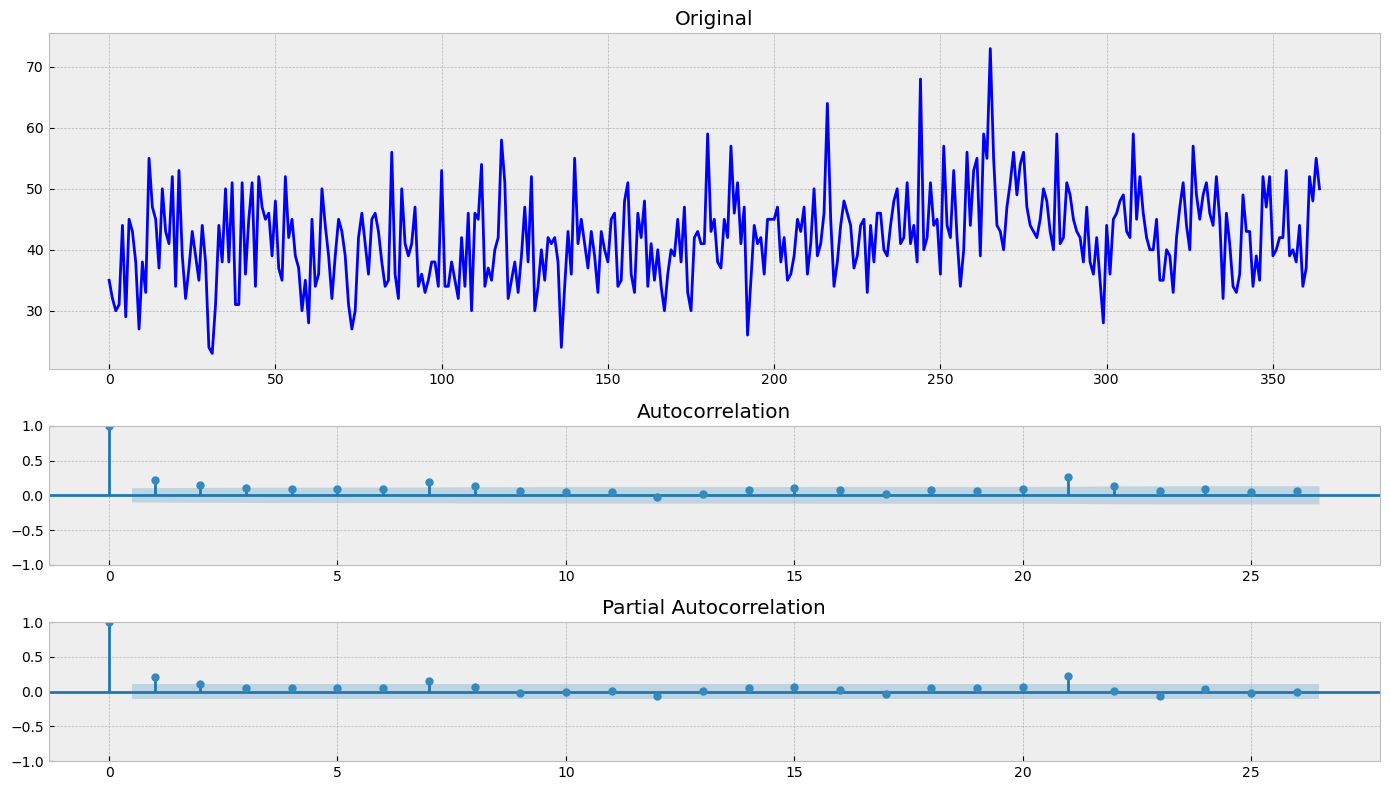

In [31]:
series = pd.read_csv("Series/daily-total-female-births-in-cal.csv")['Count']
tsplot(series)

Стационарный временной ряд. Можно использовать хоть скользящее среднее, так как нет тренда, сезонности, цикличности.

In [32]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

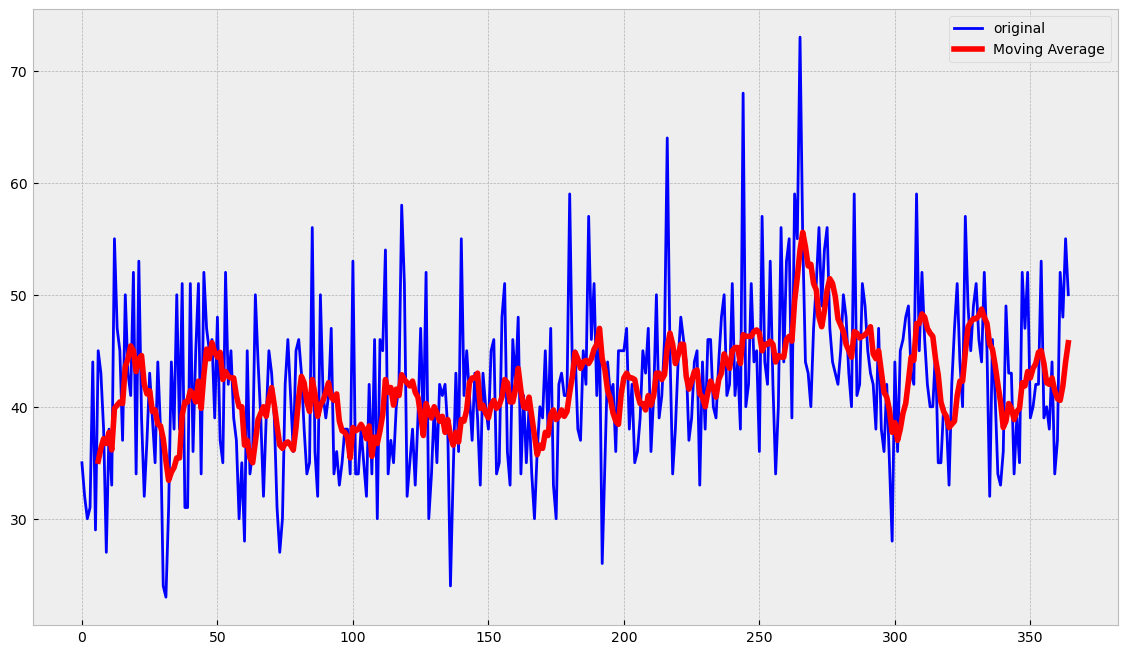

In [34]:
ser = moving_average(female_births["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Достаточно сильно сглажены пиковые значения, хотя сам ряд повторяет структуру исходного.

Попробую другое число усредняемых значений.

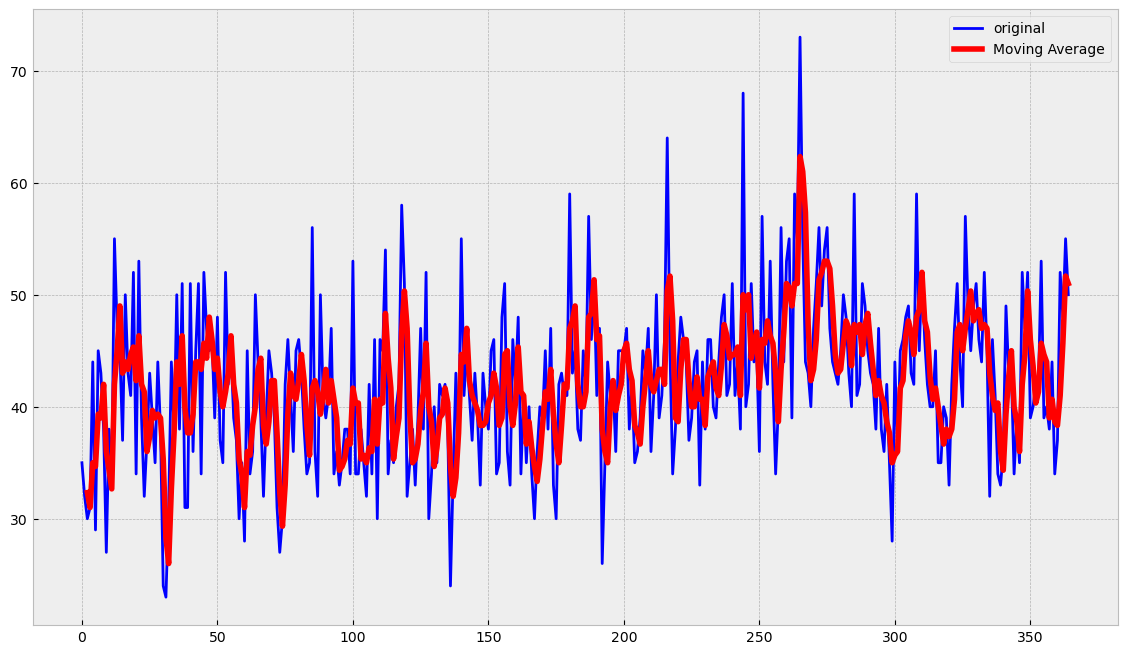

In [38]:
#поменьше
ser = moving_average(female_births["Count"], 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Можно увидеть, что только немного сглажены пиковые значения.

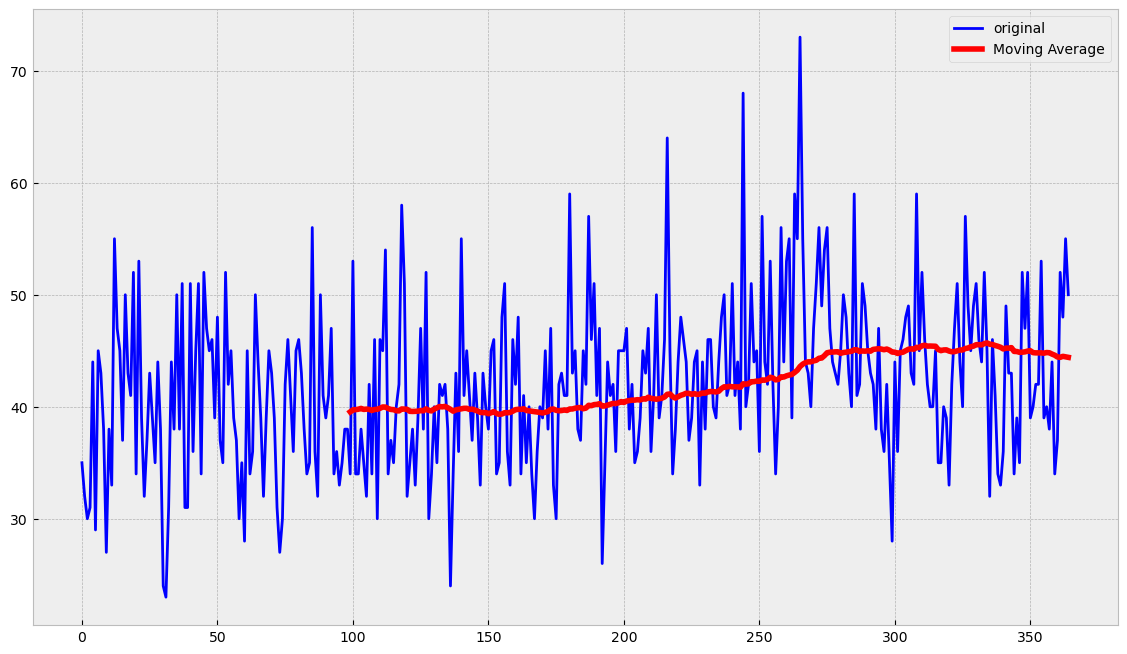

In [44]:
#побольше
ser = moving_average(female_births["Count"], 100)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

При большом значении альфа почти ничего нельзя сказать об исходном временном ряде, получилась практически прямая.

##### Вывод: 
для стационарного ряда подойдёт любой метод из класса МА, так как в стационарных рядах отсуствует сезонность, цикличность, тренд. Для временного ряда с трендом использовала двойное экспоненциальное сглаживание.

Без метрик сложно оценить качество полученных моделей, но на мой взгляд, первые варианты в обоих временных рядах получились хорошими.